In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from scipy.stats import norm
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
import time
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
def load_dataset(name, lable_in_last):
    path = os.path.join("..", "datasets", name)
    data = pd.read_csv(path)
    data = data.values
    if lable_in_last:
        xs = data[:, :-1]
        ys = data[:, -1]
    else:
        xs = data[:, 1:]
        ys = data[:, 0]
    return xs, ys

In [3]:
spam_x, spam_y = load_dataset("spam.csv", True)
cancer_x, cancer_y = load_dataset("cancer.csv", False)

In [4]:
scaler = MinMaxScaler()
spam_x = scaler.fit_transform(spam_x)
cancer_x = scaler.fit_transform(cancer_x)

cancer_y[cancer_y == 'B'] = 0
cancer_y[cancer_y == 'M'] = 1
cancer_y = cancer_y.astype("float32")

In [5]:
spam_train_x, spam_val_x, spam_train_y, spam_val_y = train_test_split(
    spam_x, spam_y, test_size=0.2)
cancer_train_x, cancer_val_x, cancer_train_y, cancer_val_y = train_test_split(
    cancer_x, cancer_y, test_size=0.2)

In [6]:
def draw_roc(ys, ys_pred, ps, dataset, name):
    fpr, tpr, _ = roc_curve(ys, ps[:, 1])
        
    plt.cla()
    plt.plot(fpr, tpr)
    plt.title("dataset = {}, accuracy on {} = {:.4f}".format(
        dataset, name, accuracy_score(ys, ys_pred)))
    plt.show()

In [7]:
def get_bayseain_classifier_prediction(xs, ys, xs_pred):
    n, k = xs.shape
    m = xs_pred.shape[0]
    
    ps = np.zeros((m, 2))
    ps[:, 0] = np.sum(ys == 0)
    ps[:, 1] = np.sum(ys == 1)
    for l in [0, 1]:
        for i in range(k):
            xs_l = xs[ys == l][:, i]
            mean = np.mean(xs_l)
            std = np.std(xs_l)
            for j, x in enumerate(xs_pred):
                ps[j, l] *= norm.pdf(x[i], loc=mean, scale=std)
                
    ps[:, 0], ps[:, 1] = ps[:, 0] / np.sum(ps, axis=1), ps[:, 1] / np.sum(ps, axis=1)
    ps = np.nan_to_num(ps)
    return np.argmax(ps, axis=1), ps

def roc_for_bayseain_classifier(train_xs, train_ys, val_xs, val_ys, dataset):
    ys_pred, ps = get_bayseain_classifier_prediction(train_xs, train_ys, val_xs)
    draw_roc(val_ys, ys_pred, ps, dataset, "val")

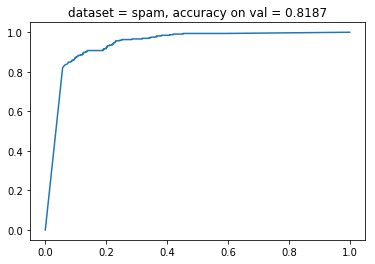

In [8]:
roc_for_bayseain_classifier(spam_train_x, spam_train_y, spam_val_x, spam_val_y, "spam")

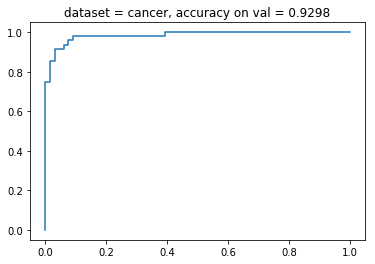

In [9]:
roc_for_bayseain_classifier(cancer_train_x, cancer_train_y, cancer_val_x, cancer_val_y, "cancer")

In [10]:
smsspam_x, smsspam_y = load_dataset("smsspam.csv", False)

In [11]:
smsspam_y[smsspam_y == "ham"] = 0
smsspam_y[smsspam_y == "spam"] = 1
smsspam_y = smsspam_y.astype("float32")

In [12]:
smsspam_train_x, smsspam_val_x, smsspam_train_y, smsspam_val_y = train_test_split(
    smsspam_x, smsspam_y, test_size=0.2)

In [13]:
def build_vocab(xs, ys):
    vocab = [Counter(), Counter()]
    words = []
    ps = PorterStemmer()
    for x, l in zip(xs, ys):
        tokens = word_tokenize(str(x[0]).lower())
        tokens = list(map(lambda t: ps.stem(t), tokens))
        vocab[int(l)].update(tokens)
        words += tokens
    words = set(words)
    return vocab, words

def get_bayseain_classifier_on_words_prediction(xs, ys, xs_pred, vocab, words):
    n, k = xs.shape
    m = xs_pred.shape[0]
    
    ps = np.zeros((m, 2))
    ps[:, 0] = np.sum(ys == 0)
    ps[:, 1] = np.sum(ys == 1)
    for l in [0, 1]:
        l_cnt = np.sum(ys == l)
        for w in words:
            for j, x in enumerate(xs_pred):
                if w in x[0]:
                    ps[j, l] *= vocab[int(l)][w] + 1
                else:
                    ps[j, l] *= l_cnt - vocab[int(l)][w] + 1
                ps[j, l] /= l_cnt + 2
                
    ps[:, 0], ps[:, 1] = ps[:, 0] / np.sum(ps, axis=1), ps[:, 1] / np.sum(ps, axis=1)
    ps = np.nan_to_num(ps)
    return np.argmax(ps, axis=1), ps

In [14]:
def roc_for_bayseain_classifier_on_words(train_xs, train_ys, val_xs, val_ys, dataset):
    vocab, words = build_vocab(smsspam_x, smsspam_y)
    ys_pred, ps = get_bayseain_classifier_on_words_prediction(train_xs, train_ys, val_xs, vocab, words)
    draw_roc(val_ys, ys_pred, ps, dataset, "val")

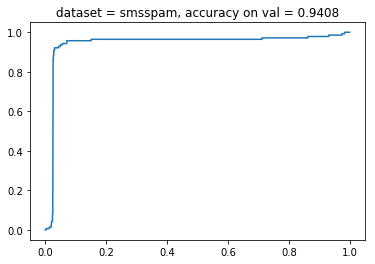

In [15]:
roc_for_bayseain_classifier_on_words(smsspam_train_x, smsspam_train_y, smsspam_val_x, smsspam_val_y, "smsspam")